In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e5/sample_submission.csv
/kaggle/input/playground-series-s3e5/train.csv
/kaggle/input/playground-series-s3e5/test.csv
/kaggle/input/wine-quality-dataset/WineQT.csv


## Must Know Things before moving on

#### Goal - The dataset describes the amount of various chemicals present in wine and their effect on it's quality. Our goal is to predict the quality (on a score of 0-10) of wine using the given data.


* Kappa Co-efficient - https://medium.com/x8-the-ai-community/kappa-coefficient-for-dummies-84d98b6f13ee
* Sklearn metric reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html
* Information on original dataset - https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

## Setup

In [2]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas #Upgrading pandas

clear_output()

In [3]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from typing import List, Union, Tuple

# Metric import
from sklearn.metrics import cohen_kappa_score

# Preprocessing imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Modeling imports
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier, Pool

# Palette
palette = sns.color_palette('plasma')

In [4]:
SEED = 42

def seed_everything(seed = 42):
    import random, os
    import numpy as np

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [5]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e5/train.csv", index_col='Id')
test_df = pd.read_csv("/kaggle/input/playground-series-s3e5/test.csv", index_col='Id')
original_df = pd.read_csv("/kaggle/input/wine-quality-dataset/WineQT.csv", index_col='Id')
sample_submission = pd.read_csv("/kaggle/input/playground-series-s3e5/sample_submission.csv")

## Exploratory Data Analysis

In [6]:
display(train_df.info())
display(test_df.info())
display(original_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 0 to 2055
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2056 non-null   float64
 1   volatile acidity      2056 non-null   float64
 2   citric acid           2056 non-null   float64
 3   residual sugar        2056 non-null   float64
 4   chlorides             2056 non-null   float64
 5   free sulfur dioxide   2056 non-null   float64
 6   total sulfur dioxide  2056 non-null   float64
 7   density               2056 non-null   float64
 8   pH                    2056 non-null   float64
 9   sulphates             2056 non-null   float64
 10  alcohol               2056 non-null   float64
 11  quality               2056 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 208.8 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1372 entries, 2056 to 3427
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1372 non-null   float64
 1   volatile acidity      1372 non-null   float64
 2   citric acid           1372 non-null   float64
 3   residual sugar        1372 non-null   float64
 4   chlorides             1372 non-null   float64
 5   free sulfur dioxide   1372 non-null   float64
 6   total sulfur dioxide  1372 non-null   float64
 7   density               1372 non-null   float64
 8   pH                    1372 non-null   float64
 9   sulphates             1372 non-null   float64
 10  alcohol               1372 non-null   float64
dtypes: float64(11)
memory usage: 128.6 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143 entries, 0 to 1597
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 116.1 KB


None

In [7]:
display(train_df.head())
display(test_df.head())
display(original_df.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,8.00,0.50,0.39,2.20,0.07,30.00,39.00,1.00,3.33,0.77,12.10,6
1,9.30,0.30,0.73,2.30,0.09,30.00,67.00,1.00,3.32,0.67,12.80,6
2,7.10,0.51,0.03,2.10,0.06,3.00,12.00,1.00,3.52,0.73,11.30,7
3,8.10,0.87,0.22,2.60,0.08,11.00,65.00,1.00,3.20,0.53,9.80,5
4,8.50,0.36,0.30,2.30,0.08,10.00,45.00,0.99,3.20,1.36,9.50,6


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
2056,7.20,0.51,0.01,2.00,0.08,31.00,54.00,1.00,3.39,0.59,9.80
2057,7.20,0.76,0.15,2.00,0.10,14.00,35.00,1.00,3.33,0.68,10.00
2058,8.40,0.46,0.40,2.00,0.07,21.00,50.00,1.00,3.08,0.65,9.50
2059,8.00,0.47,0.40,1.80,0.06,14.00,25.00,0.99,3.30,0.65,11.70
2060,6.50,0.34,0.32,2.10,0.04,8.00,94.00,0.99,3.23,0.48,12.80


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5


In [8]:
TARGET = 'quality'
pd.concat([
    pd.DataFrame(train_df.drop(columns=[TARGET]).isnull().sum(), columns=['missing train']),
    pd.DataFrame(test_df.isnull().sum(), columns=['missing test']),
    pd.DataFrame(original_df.drop(columns=[TARGET]).isnull().sum(), columns=['missing original'])
], axis=1)

,missing train,missing test,missing original
fixed acidity,0,0,0
volatile acidity,0,0,0
citric acid,0,0,0
residual sugar,0,0,0
chlorides,0,0,0
free sulfur dioxide,0,0,0
total sulfur dioxide,0,0,0
density,0,0,0
pH,0,0,0
sulphates,0,0,0


### Observations so far:
* No Null Values in Dataset
* All Numerical Columns
* Target Variable is an integer value
* Fewer samples in dataset

### Features Descriptions
* Fixed acidity : most acids involved with wine or fixed or nonvolatile (do not evaporate readily).

* Volatile acidity : the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.

* Citric acid : found in small quantities, citric acid can add 'freshness' and flavor to wines.

* Residual sugar : the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet.

* Chlorides : the amount of salt in the wine.

* Free sulfur dioxide : the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.

* Total sulfur dioxide : amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine.

* Density : the density of wine is close to that of water depending on the percent alcohol and sugar content.

* pH : describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.

* Sulphates : a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant.

* Alcohol : the percent alcohol content of the wine.

* Quality : wine quality rating

In [9]:
display(train_df.describe())
display(test_df.describe())
display(original_df.describe())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00
mean,8.37,0.53,0.27,2.40,0.08,16.96,49.24,1.00,3.31,0.64,10.41,5.72
std,1.71,0.17,0.19,0.86,0.02,10.01,32.96,0.00,0.14,0.14,1.03,0.85
min,5.00,0.18,0.00,1.20,0.01,1.00,7.00,0.99,2.74,0.39,8.70,3.00
25%,7.20,0.39,0.09,1.90,0.07,8.00,22.00,1.00,3.20,0.55,9.50,5.00
50%,7.95,0.52,0.25,2.20,0.08,16.00,44.00,1.00,3.31,0.61,10.10,6.00
75%,9.20,0.64,0.42,2.60,0.09,24.00,65.00,1.00,3.39,0.72,11.00,6.00
max,15.90,1.58,0.76,14.00,0.41,68.00,289.00,1.00,3.78,1.95,14.00,8.00


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00
mean,8.37,0.52,0.27,2.42,0.08,17.16,49.09,1.00,3.31,0.65,10.47
std,1.66,0.18,0.19,0.92,0.03,9.97,32.80,0.00,0.14,0.13,1.03
min,4.90,0.12,0.00,1.30,0.01,1.00,8.00,0.99,2.74,0.39,8.80
25%,7.10,0.39,0.11,2.00,0.07,8.00,23.00,1.00,3.21,0.55,9.60
50%,7.90,0.50,0.26,2.20,0.08,16.00,43.00,1.00,3.31,0.62,10.20
75%,9.10,0.64,0.42,2.50,0.09,24.00,66.00,1.00,3.39,0.73,11.20
max,15.60,1.33,0.76,8.30,0.47,68.00,165.00,1.00,4.01,1.62,14.00


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00
mean,8.31,0.53,0.27,2.53,0.09,15.62,45.91,1.00,3.31,0.66,10.44,5.66
std,1.75,0.18,0.20,1.36,0.05,10.25,32.78,0.00,0.16,0.17,1.08,0.81
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,21.00,1.00,3.21,0.55,9.50,5.00
50%,7.90,0.52,0.25,2.20,0.08,13.00,37.00,1.00,3.31,0.62,10.20,6.00
75%,9.10,0.64,0.42,2.60,0.09,21.00,61.00,1.00,3.40,0.73,11.10,6.00
max,15.90,1.58,1.00,15.50,0.61,68.00,289.00,1.00,4.01,2.00,14.90,8.00


#### Distribution of each of the columns

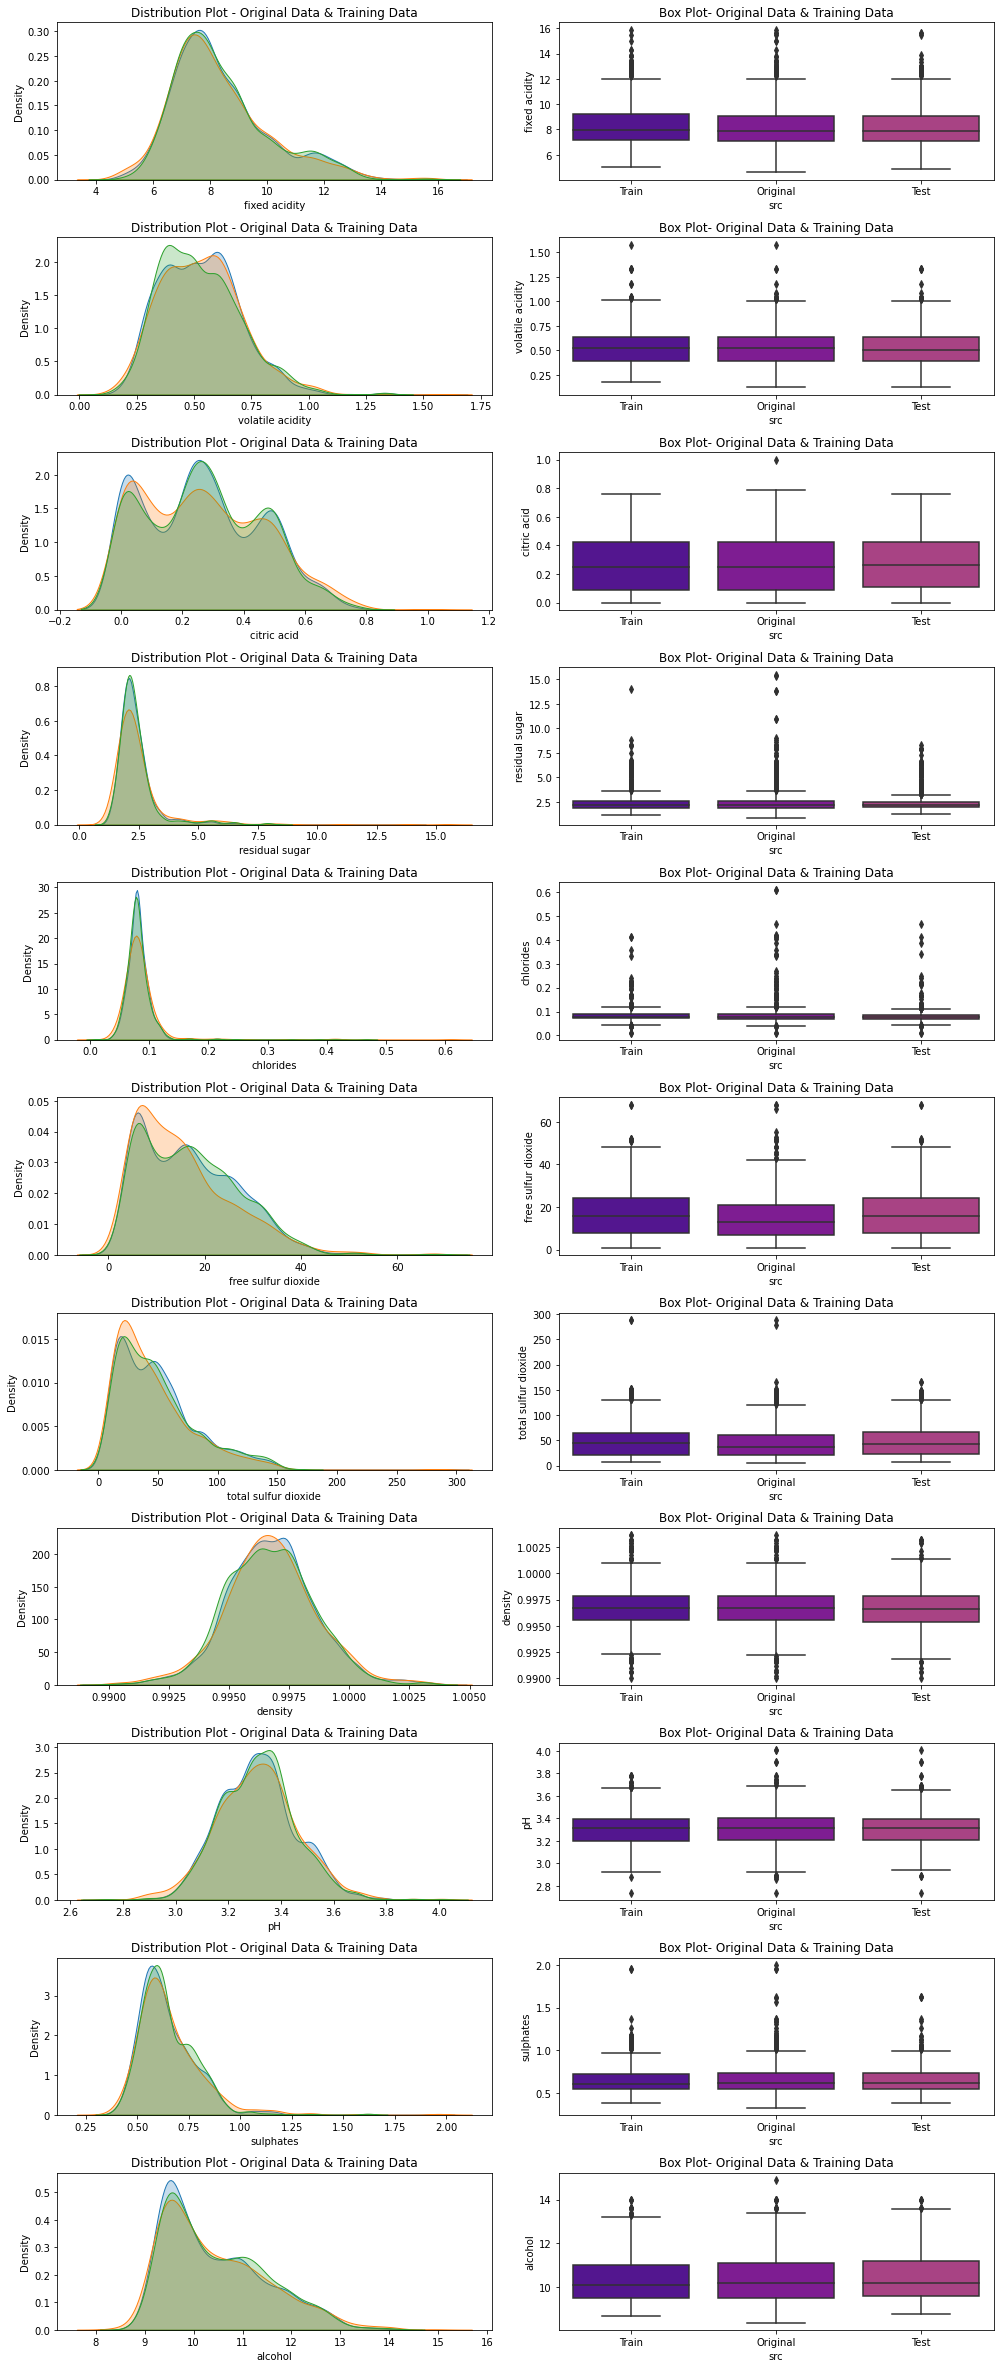

In [10]:
ncols = 2
cont_features=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

nrows = len(cont_features)
df_temp=pd.concat([train_df.assign(src='Train'),original_df.assign(src='Original'),test_df.assign(src='Test')])
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3*nrows))

for r in range(nrows):
    row = cont_features[r]
   
    sns.kdeplot(x=train_df[row], ax=axes[r,0], palette=palette, label='Train data', fill =True)
    sns.kdeplot(x=original_df[row], ax=axes[r,0], palette=palette, label='Original data' , fill =True )
    sns.kdeplot(x=test_df[row], ax=axes[r,0], palette=palette, label='Test data', fill =True)
    
    sns.boxplot(data=df_temp, y=row,x='src' ,ax=axes[r,1],palette=palette)


    axes[r,0].title.set_text("Distribution Plot - Original Data & Training Data")
    axes[r,1].title.set_text("Box Plot- Original Data & Training Data")
fig.tight_layout()
plt.show()

#### Insight:
* All variables except Quality are continuous.
* Original and Training Data follow the same distribution so they can be combined.
* We can also see the presence of outliers in some of the columns.

#### Combining original and train datasets

In [11]:
combined_df = pd.concat([train_df, original_df], ignore_index=True)

In [12]:
def plot_num_features(data: pd.DataFrame, 
                      num_features: List[str], 
                      target: str, 
                      palette: Union[str, dict], 
                      figsize: Tuple[int, int]) -> None:

    # Loop over numerical features
    for feature in num_features:
        fig, axs = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'{feature} distribution', fontsize=24)

        # Kdeplot
        sns.kdeplot(data=data, x=feature, hue=target, alpha=0.6,edgecolor='black', 
                    palette=palette, fill=True, common_norm=False, ax=axs[0])

        axs[0].set_xlabel('')
        axs[0].set_ylabel('Density', fontsize=16)

        # Boxpot
        sns.boxplot(data=data.astype({target: str}), y=target, x=feature, ax=axs[1],
                    width=0.5, fliersize=3, showmeans=True, notch=True, palette=palette, 
                    medianprops={'color': 'black'}, meanprops={'markerfacecolor': 'white', 
                                                               'markeredgecolor': 'black',
                                                               'markersize': '7'})

        axs[1].set_xlabel('')
        axs[1].set_ylabel(target, fontsize=16)

        # QQplot
        stats.probplot(data[feature], plot=axs[2])

        axs[2].set_title('')
        axs[2].set_xlabel('')
        axs[2].set_ylabel('Ordered values', fontsize=16)

        lines = axs[2].get_lines()

        lines[0].set_color('#4b159f')
        lines[0].set_markerfacecolor('#4b159f')
        lines[0].set_alpha(0.6)

        lines[1].set_color('#f48849')
        lines[1].set_linewidth(3.0)
        
        plt.tight_layout(pad=2)
        plt.show()

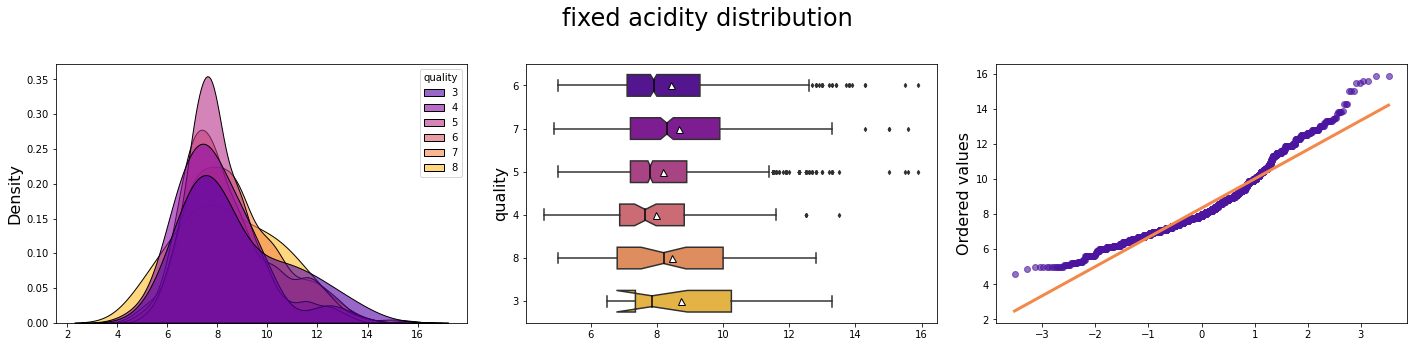

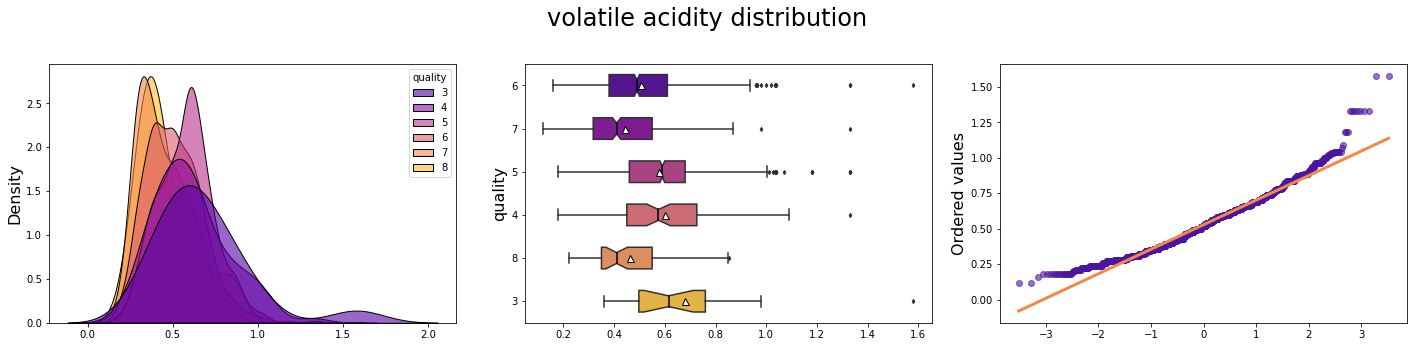

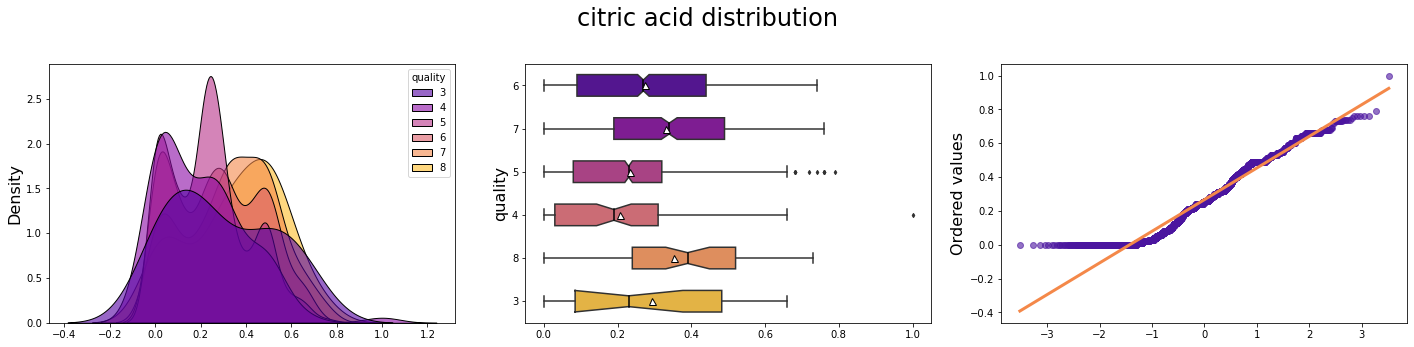

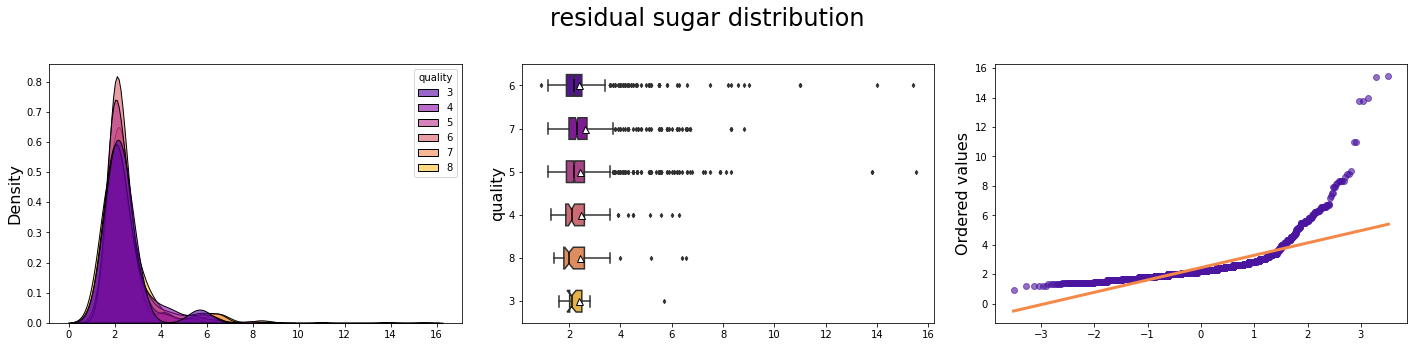

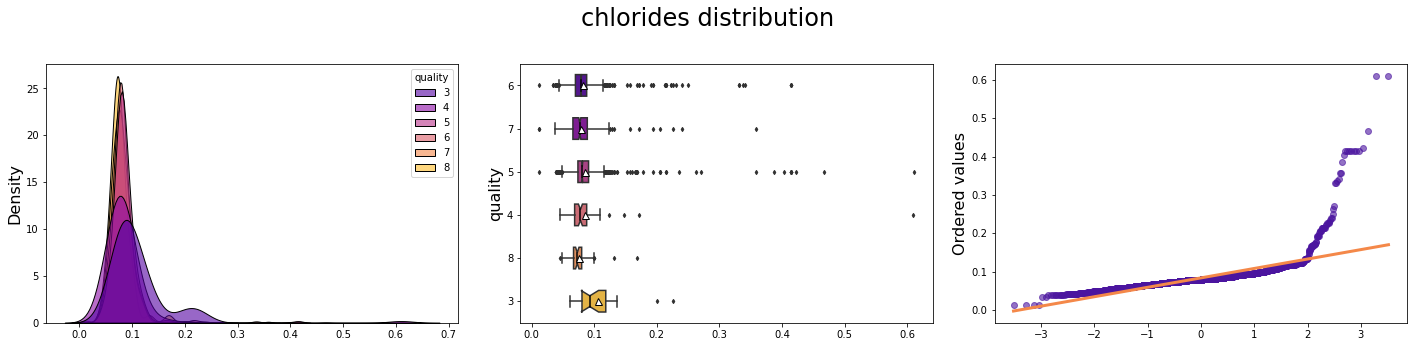

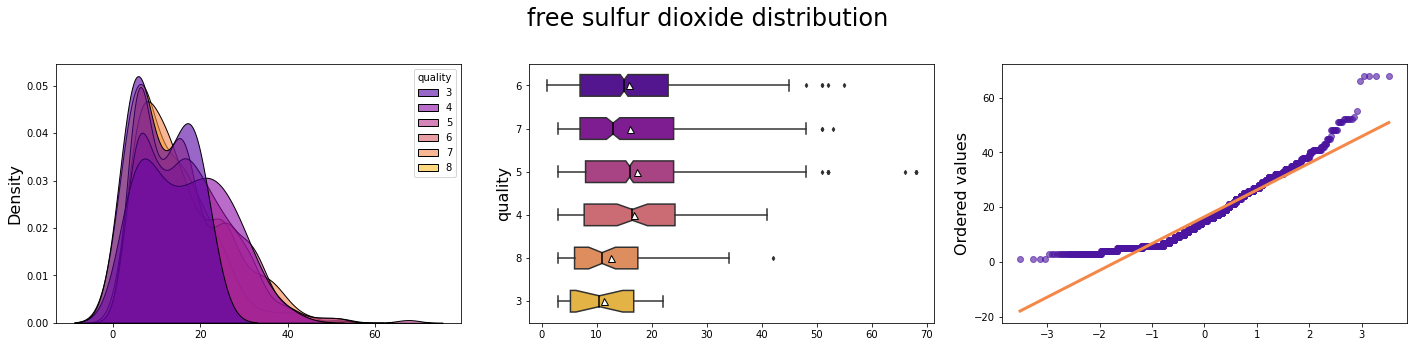

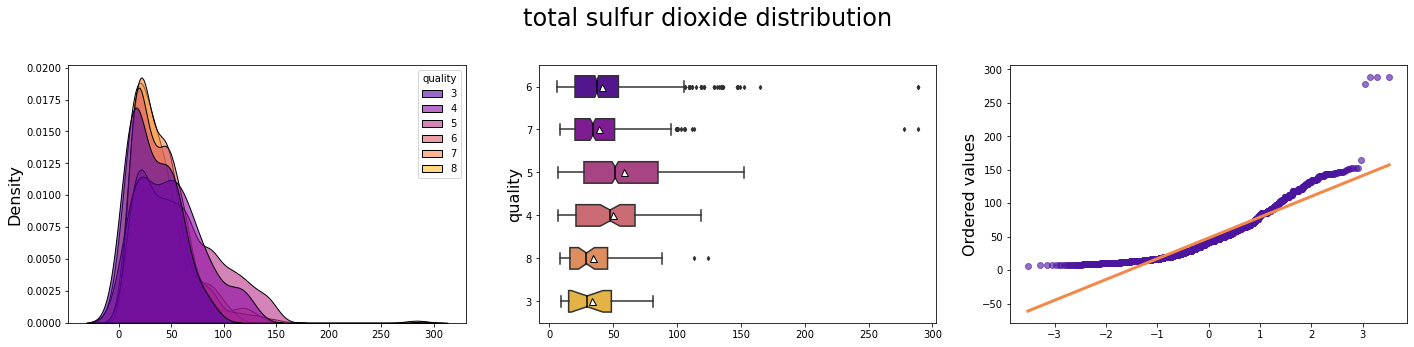

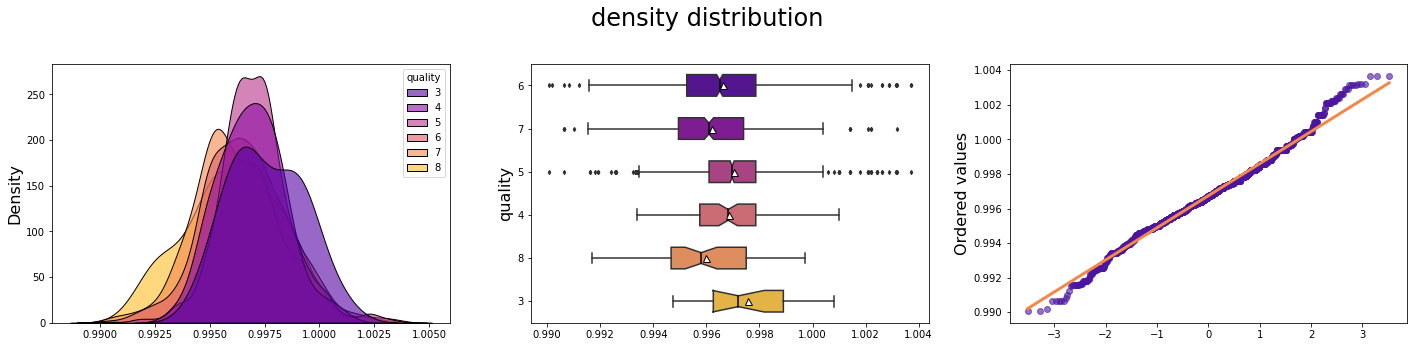

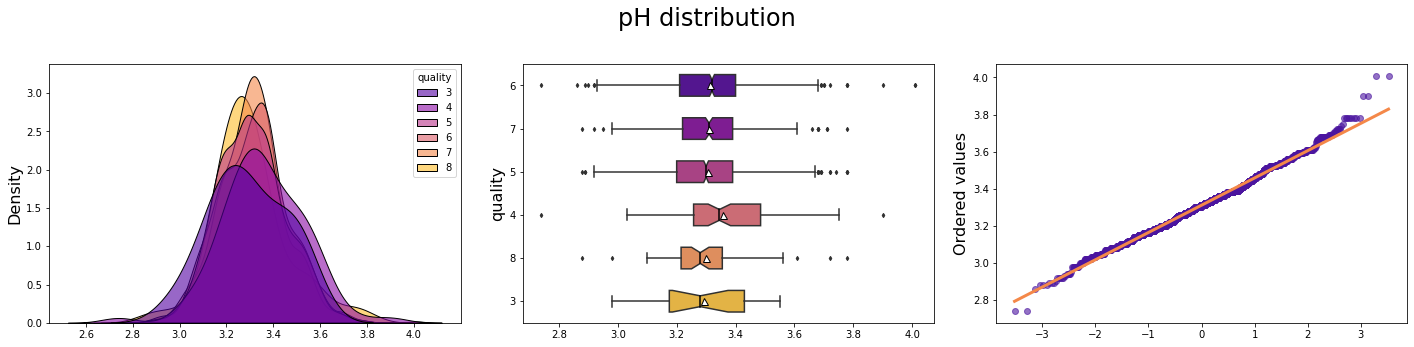

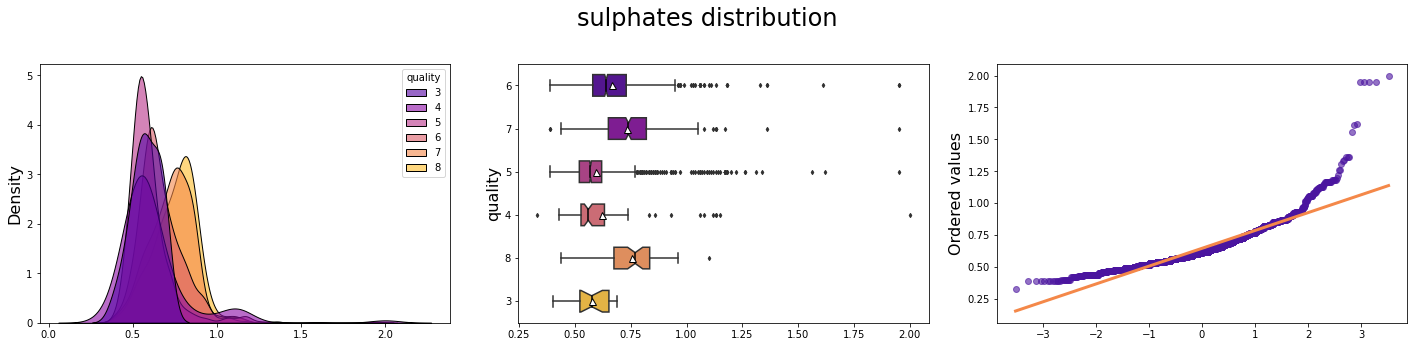

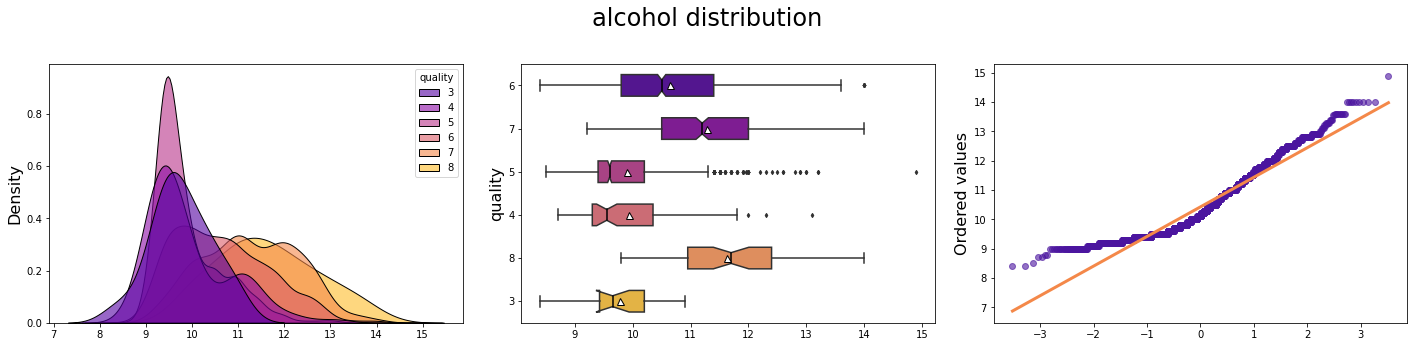

In [13]:
features = combined_df.columns[combined_df.columns != TARGET]
plot_num_features(data=combined_df,
                  num_features=features, target=TARGET,
                  palette=palette, figsize=(20, 5))

#### Handling Outliers

In [14]:
def handle_outliers(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr_range = q3 - q1
        
        upper_cap = q3 + 2.5*iqr_range
        lower_cap = q1 - 2.5*iqr_range
        
        df[column] = np.clip(df[column], lower_cap, upper_cap)
    return df

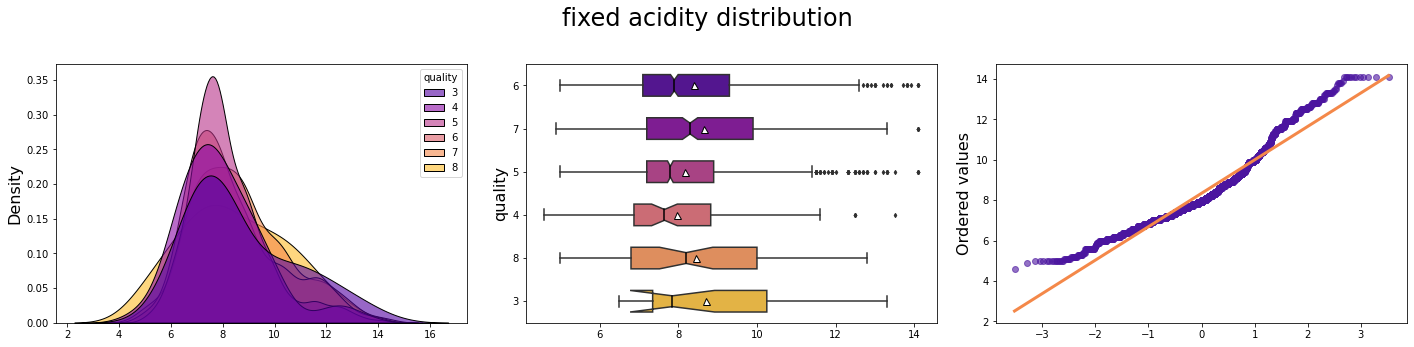

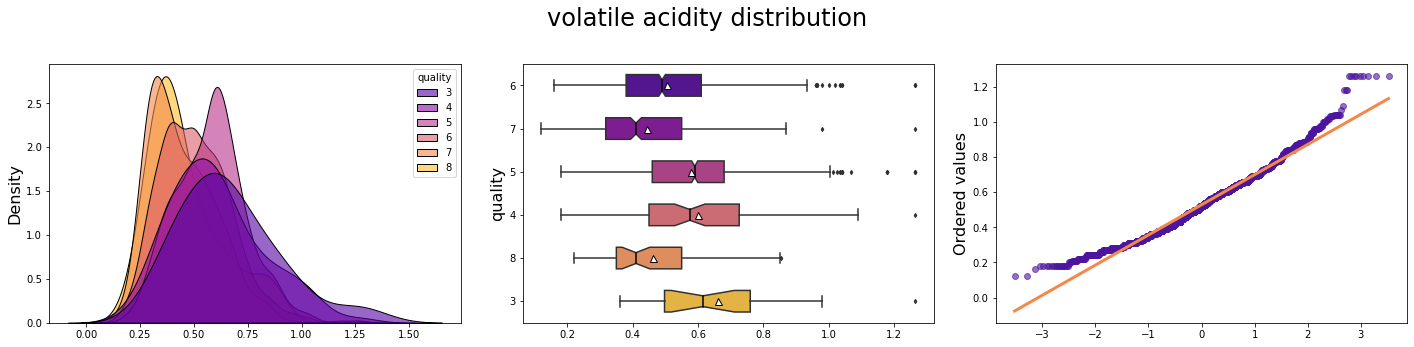

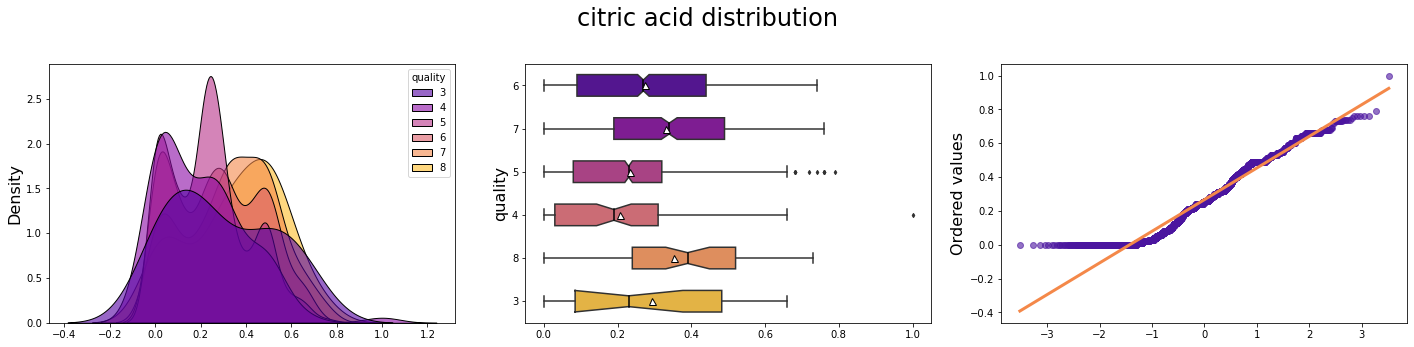

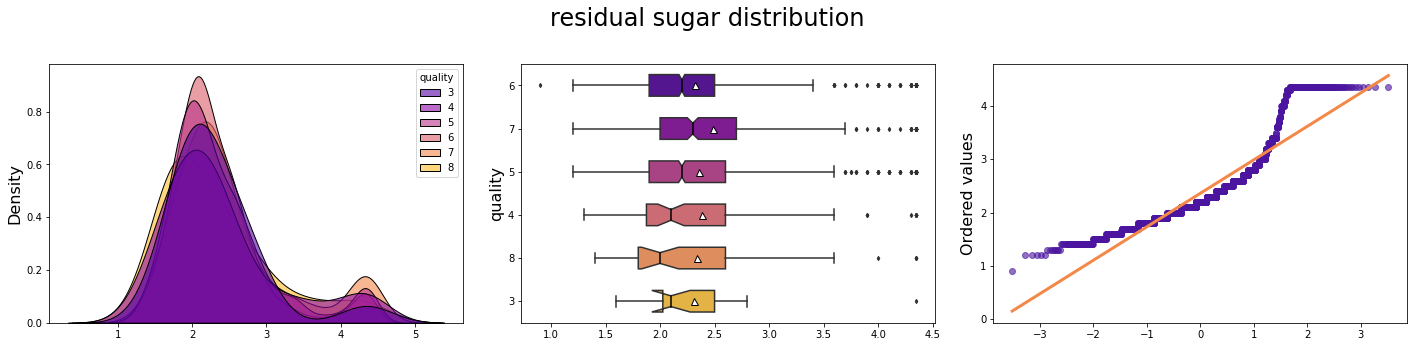

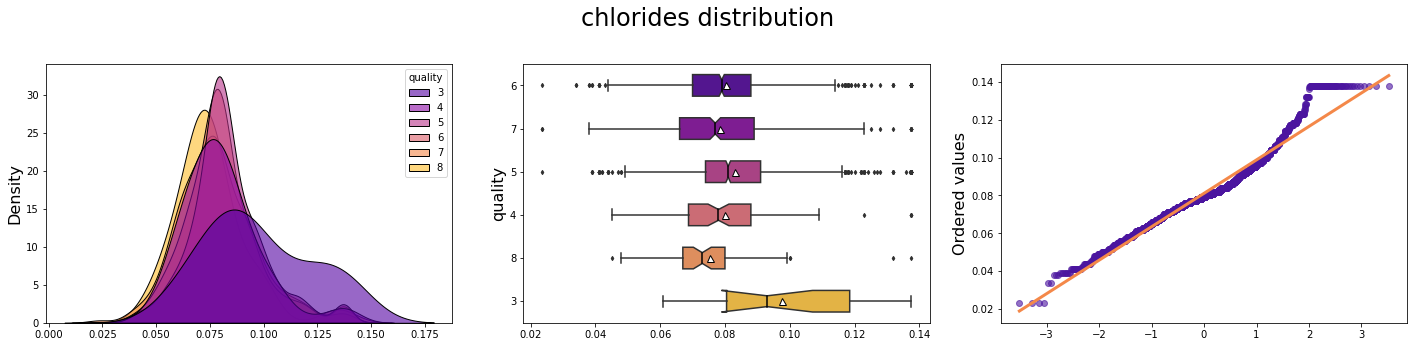

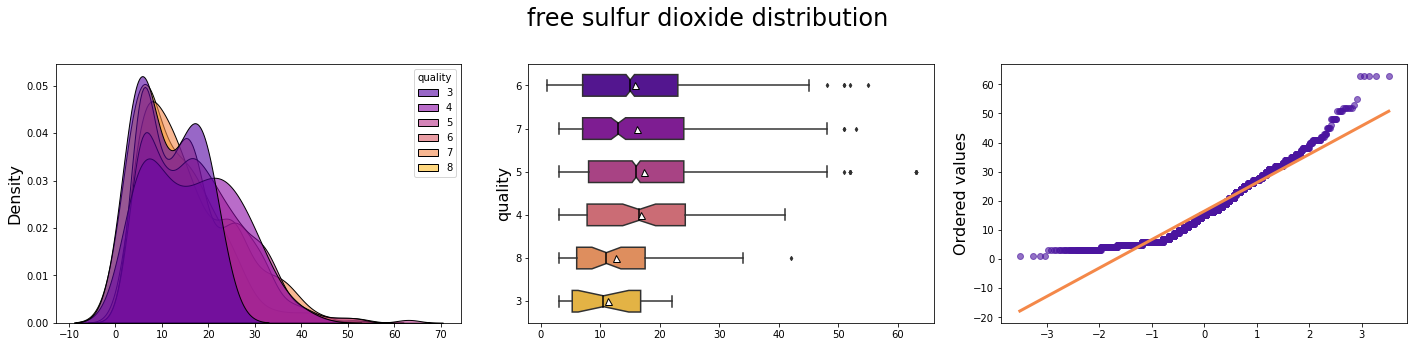

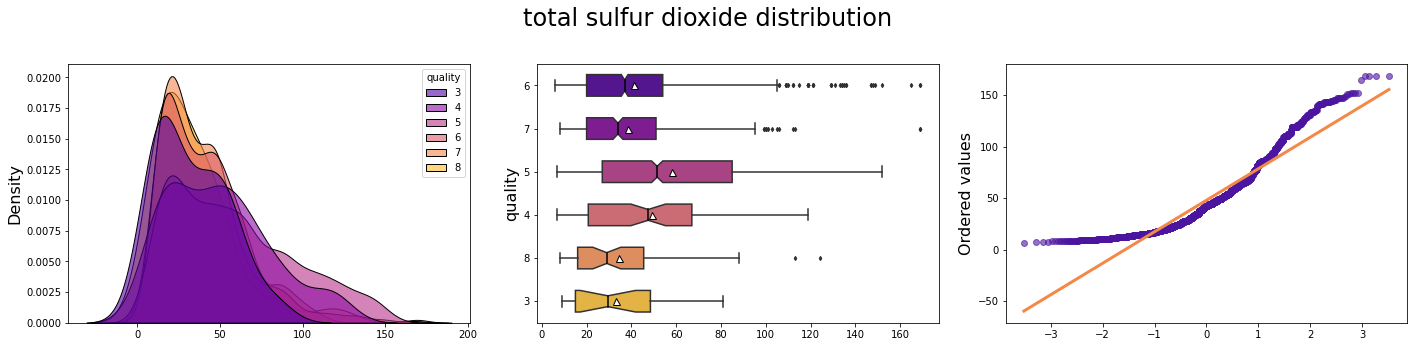

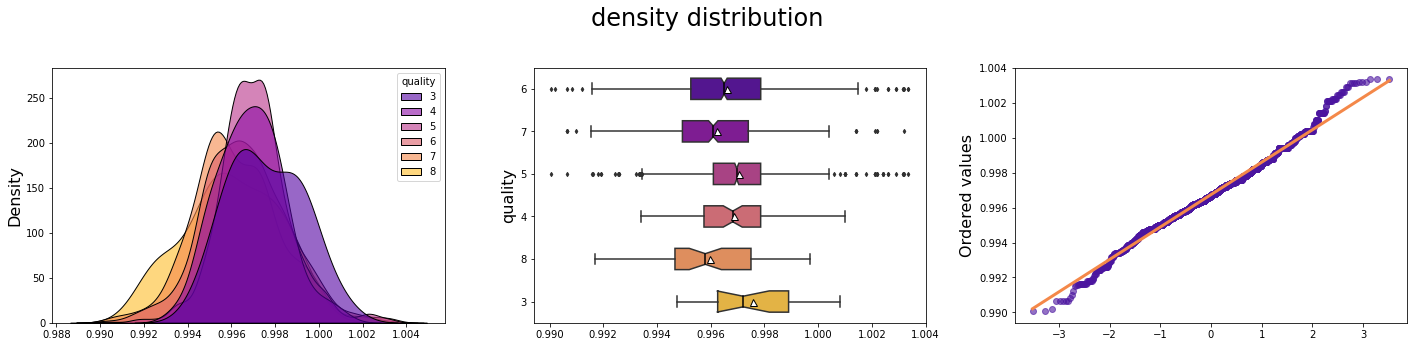

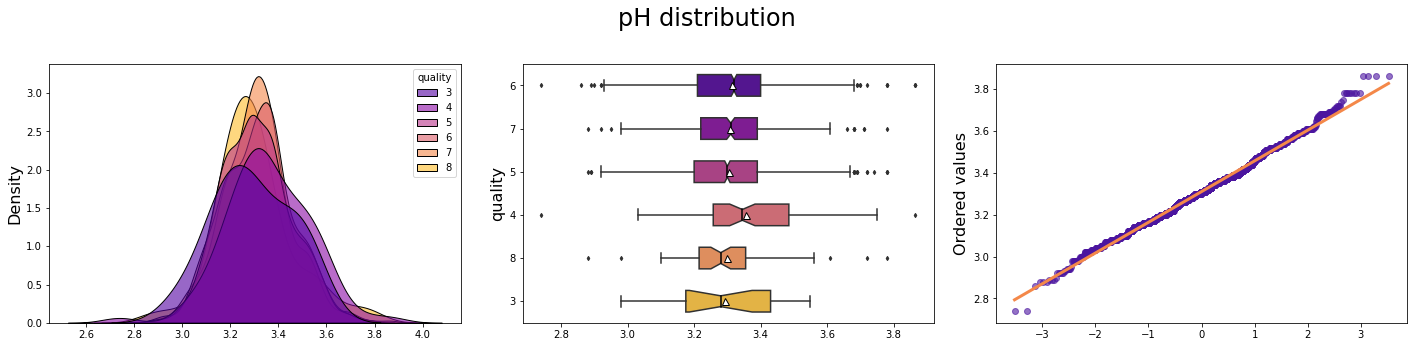

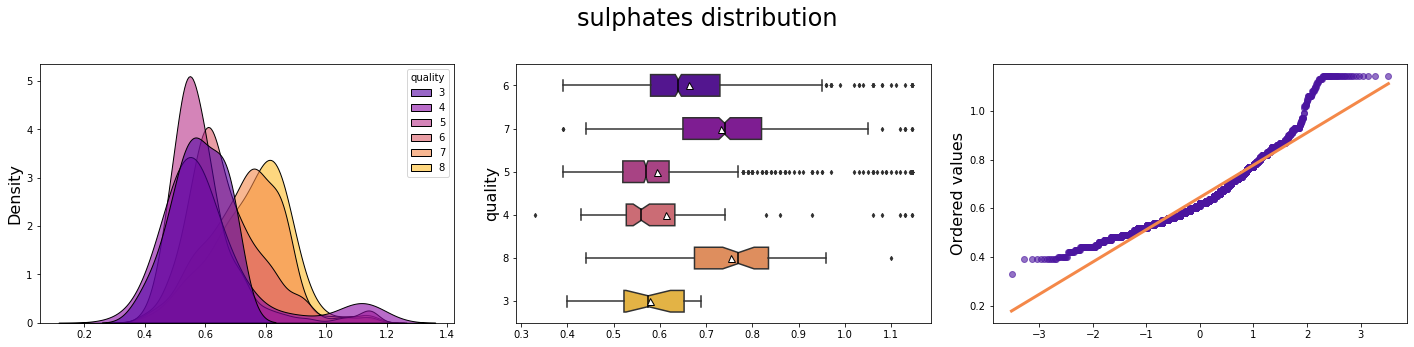

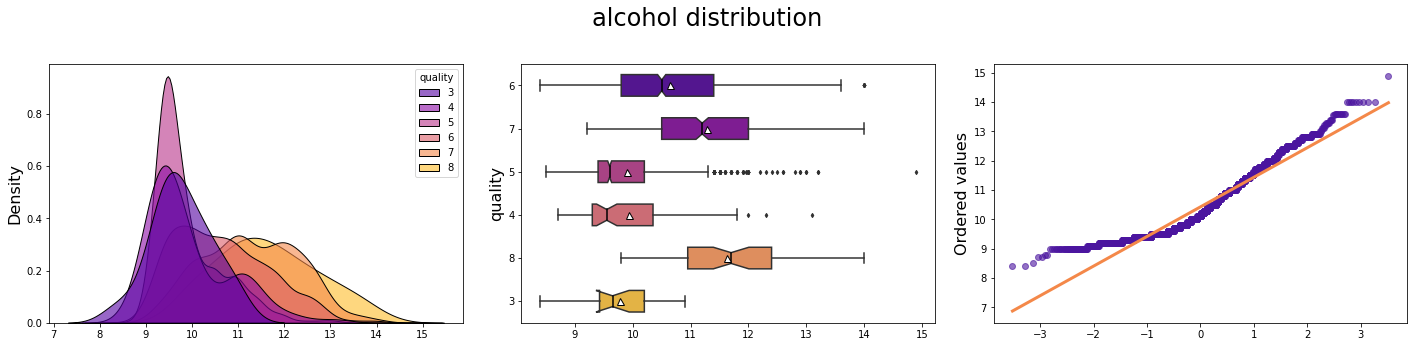

In [15]:
combined_df = handle_outliers(combined_df, features)
plot_num_features(data=combined_df,
                  num_features=features, target=TARGET,
                  palette=palette, figsize=(20, 5))

#### Studying the Target Variable

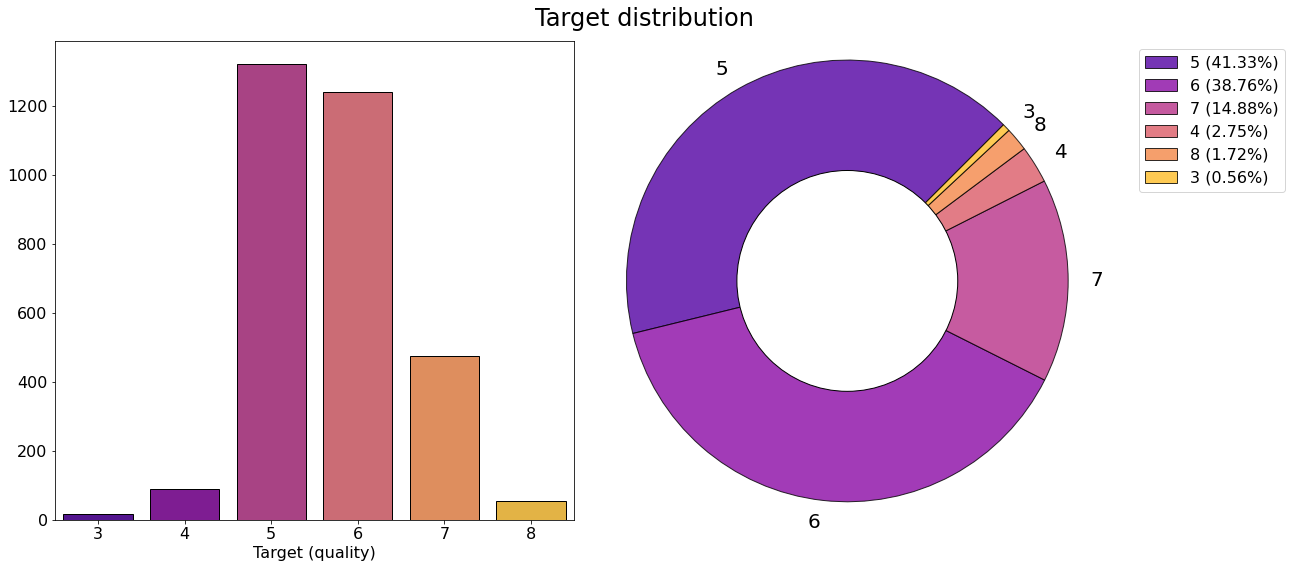

In [16]:
# Create the figure and subplots
TARGET = 'quality'
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Target distribution', fontsize=24)

# Plot the countplot
sns.countplot(x=TARGET, data=combined_df, alpha=1, palette=palette, edgecolor='black', ax=ax[0])
ax[0].set_xlabel(f'Target ({TARGET})', fontsize=16)
ax[0].set_ylabel('')
ax[0].tick_params(axis='both', labelsize=16)

# Get the counts of each class in the target column
target_counts = combined_df[TARGET].value_counts()

# Plot the pie chart
ax[1].pie(target_counts, labels=target_counts.index, startangle=45, colors=palette, pctdistance=0.3,
          textprops={'fontsize': 20}, wedgeprops={'alpha': 0.8, 'edgecolor': 'black', 'linewidth': 1})
ax[1].axis('equal')  # Ensure the pie is drawn as a circle

# Add the legend with target values and percentage
legend_entries = [f'{label} ({count/len(combined_df)*100:.2f}%)' for label, count in target_counts.items()]
ax[1].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

# Draw circle
centre_circle = plt.Circle((0, 0), 0.5, fc='white', edgecolor='black')
fig = plt.gcf()
  
# Adding circle in Pie chart
fig.gca().add_artist(centre_circle)

# Tighten the layout and show the figure
plt.tight_layout()
plt.show()

#### Insights:
* Target variable - quality is highly imbalanced. It makes sense because there are more number of normal quality wines than there are extremely bad or good wines.
* quality can range between 0-10 but actually the range is from 3-8 in the dataset

#### Correlation Matrix


In [17]:
correlation = combined_df.corr()

print(correlation[TARGET].sort_values(ascending=False),'\n')

quality                 1.00
alcohol                 0.48
sulphates               0.35
citric acid             0.18
fixed acidity           0.09
residual sugar          0.04
pH                     -0.01
free sulfur dioxide    -0.06
chlorides              -0.11
density                -0.16
total sulfur dioxide   -0.22
volatile acidity       -0.29
Name: quality, dtype: float64 



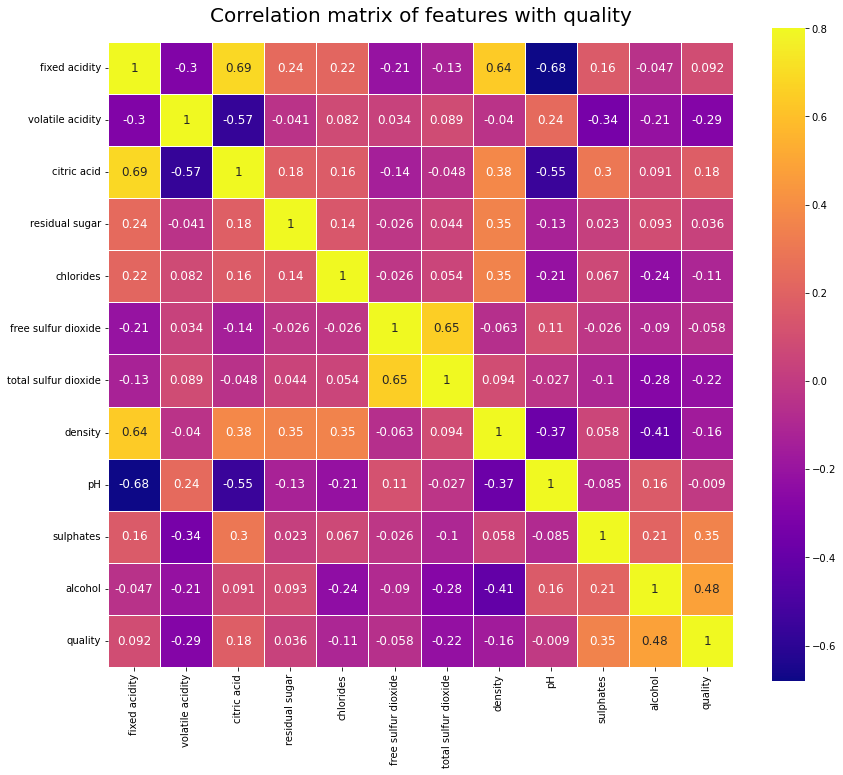

In [18]:
cols = correlation.index
corr_matrix = np.corrcoef(combined_df.to_numpy().T)

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, vmax=.8, linewidths=0.5, square=True, annot=True,
            cmap='plasma', annot_kws={'size': 12}, xticklabels=cols, yticklabels=cols)

# Add title to the plot
plt.title(f'Correlation matrix of features with {TARGET}', fontsize=20, pad=20)

# Increase the size of axes values
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)

plt.show()

In [19]:
# Threshold for correlation value
threshold = 0.5

# Get the high-correlated pairs of columns, excluding auto-correlations
corr_pairs = (
    correlation[abs(correlation) > threshold][correlation != 1.0]
).unstack().dropna().to_dict()

# Remove duplicate pairs and create a dataframe with unique pairs
unique_corr_pairs = pd.DataFrame(
    list(
        set([(tuple(sorted(key)), corr_pairs[key]) for key in corr_pairs])
    ), columns=['pair', 'corr']
)

# Show the unique pairs and their correlation value
unique_corr_pairs

,pair,corr
0,"(citric acid, volatile acidity)",-0.57
1,"(density, fixed acidity)",0.64
2,"(fixed acidity, pH)",-0.68
3,"(citric acid, fixed acidity)",0.69
4,"(free sulfur dioxide, total sulfur dioxide)",0.65
5,"(citric acid, pH)",-0.55


## Train-Test split

In [20]:
X = combined_df.drop(columns=['quality'])
print(X.shape)
y = combined_df.quality
print(y.shape)

(3199, 11)
(3199,)


In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,
                                                        test_size=0.1, 
                                                        stratify=y, 
                                                        random_state=SEED)

## Modeling

In [22]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=cohen_kappa_score)
models,predictions = clf.fit(X_train, X_valid, y_train, y_valid)
models

100%|██████████| 29/29 [00:10<00:00,  2.70it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,cohen_kappa_score,Time Taken
Model,,,,,,
NearestCentroid,0.26,0.49,None,0.30,0.12,0.02
AdaBoostClassifier,0.29,0.34,None,0.28,0.06,0.24
BaggingClassifier,0.59,0.29,None,0.57,0.34,0.20
Perceptron,0.48,0.29,None,0.46,0.24,0.02
ExtraTreesClassifier,0.61,0.29,None,0.58,0.37,0.52
RandomForestClassifier,0.59,0.28,None,0.57,0.34,0.76
LGBMClassifier,0.59,0.28,None,0.57,0.34,1.81
BernoulliNB,0.57,0.28,None,0.55,0.32,0.02
GaussianNB,0.53,0.27,None,0.51,0.26,0.02


In [23]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

## Submission

In [24]:
ytest_pred = clf.predict(test_df)

In [25]:
output = sample_submission.copy()
output['quality'] = ytest_pred
output.head()

,Id,quality
0,2056,6
1,2057,6
2,2058,6
3,2059,6
4,2060,5


In [26]:
output.to_csv('./solution.csv', index=False)

### Reference notebooks that helped:
I have rigorously looked at the below notebooks and picked out points that made sense to me the most. I am trying to learn as much as I can from notebooks presented by the expert contributors mentioned below to reach a point where I can put together my own notebook soon :)

- https://www.kaggle.com/code/phongnguyen1/yet-another-eda/notebook
- https://www.kaggle.com/code/abhi011097/s3-e5-eda-multi-approach-models-w-o-smote
- https://www.kaggle.com/code/maxencefzr/ps-s3e5-eda-modelling-ensembling